
# Overplotting field lines on AIA maps

This example shows how to take a PFSS solution, trace some field lines, and
overplot the traced field lines on an AIA 193 map.


In [1]:
import os
from sunpy.net import attrs as attrs
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import sunpy.map
from astropy.coordinates import SkyCoord
import gzip
from sunpy.net import Fido
import pfsspy
import pfsspy.tracing as tracing
from pfsspy.sample_data import get_gong_map
from astropy.visualization.wcsaxes.wcsapi import wcsapi_to_celestial_frame
from sunpy.coordinates.utils import get_limb_coordinates

In [2]:
def SecondMin(a):
    min_idx = np.argmin(a)
    b = np.copy(a)
    b[min_idx] = np.max(b)
    second_min_idx = np.argmin(b)
    return min_idx, second_min_idx


In [3]:
# 去掉位于太阳背面的数据点
def remove_field_lines_without_in_visible_disk(field_line):
    obstime = field_line.coords.obstime
    observer = field_line.coords.observer
    temp_lon = field_line.coords.lon.value
    temp_lat = field_line.coords.lat.value
    temp_radius = field_line.coords.radius.to_value(u.R_sun)

    limb_lon = limb_coord.lon.value
#     limb_lon[limb_lon<90] = limb_lon[limb_lon<90] + 360
    limb_lat = limb_coord.lat.value

    clear_data_lon = np.array([])*u.deg
    clear_data_lat = np.array([])*u.deg
    clear_data_radius = np.array([])*u.m

    for idx in range(temp_lon.size):
        x_arcsec, y_arcsec = Carrington_To_Helioprojective(temp_lon[idx], temp_lat[idx], temp_radius[idx], obstime, observer=observer)

        if (x_arcsec**2 + y_arcsec**2) > 960**2:
            clear_data_lon = np.append(clear_data_lon, temp_lon[idx]*u.deg)
            clear_data_lat = np.append(clear_data_lat, temp_lat[idx]*u.deg)
            clear_data_radius = np.append(clear_data_radius,temp_radius[idx]*u.m)
        else:
            idx_current_lat_1, idx_current_lat_2 = SecondMin(np.abs(temp_lat[idx]-limb_lat))
        #     print(limb_lon[idx_current_lat_1])
            if limb_lon[idx_current_lat_1] > limb_lon[idx_current_lat_2]:
                limb_lon_min = limb_lon[idx_current_lat_2]
                limb_lon_max = limb_lon[idx_current_lat_1]
            if limb_lon[idx_current_lat_1] <= limb_lon[idx_current_lat_2]:
                limb_lon_min = limb_lon[idx_current_lat_1]
                limb_lon_max = limb_lon[idx_current_lat_2]
            if (temp_lon[idx] > limb_lon_min) and (temp_lon[idx] < limb_lon_max):
                clear_data_lon = np.append(clear_data_lon, temp_lon[idx]*u.deg)
                clear_data_lat = np.append(clear_data_lat, temp_lat[idx]*u.deg)
                clear_data_radius = np.append(clear_data_radius,temp_radius[idx]*u.m)
    clear_field_line_coords = SkyCoord(clear_data_lon,clear_data_lat,clear_data_radius,
                         frame=gong_map.coordinate_frame)
    return clear_field_line_coords

Load a GONG magnetic field map



In [4]:
def uncompress_file(fn_in, fn_out):
    f_in = gzip.open(fn_in, 'rb')
    f_out = open(fn_out, 'wb')
    file_content = f_in.read()
    f_out.write(file_content)
    f_out.close()
    f_in.close()
    
query = (attrs.Time('2020/01/24 22:30:00', '2020/01/24 23:29:00'),
             attrs.Instrument('GONG'),
             attrs.Physobs.los_magnetic_field)

result = Fido.search(*query)
print(result)

data_dir = '/Users/chuanpenghou/research/work/MFL/data/GONG/'
downloaded_file = Fido.fetch(result, path=data_dir + '{file}', overwrite=True)
filename = downloaded_file[0]
print('filename: ', filename)
filename_out = filename.rstrip('.gz')
uncompress_file(filename, filename_out)
filename = filename_out
print('filename_out: ', filename_out)

gong_map = sunpy.map.Map(filename)

Results from 1 Provider:

1 Results from the GONGClient:
Source: https://gong2.nso.edu/oQR/zqs

       Start Time               End Time        ... Provider ExtentType
----------------------- ----------------------- ... -------- ----------
2020-01-24 23:04:00.000 2020-01-24 23:04:59.999 ...      NSO   SYNOPTIC




Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

mrzqs200124t2304c2226_055.fits.gz:   0%|          | 0.00/242k [00:00<?, ?B/s]

filename:  /Users/chuanpenghou/research/work/MFL/data/GONG/mrzqs200124t2304c2226_055.fits.gz
filename_out:  /Users/chuanpenghou/research/work/MFL/data/GONG/mrzqs200124t2304c2226_055.fits


Load the corresponding AIA 193 map



In [5]:
from astropy.time import Time
from sunpy.net import attrs as a

start_time = Time('2020-01-24T22:50:16', scale='utc', format='isot')
# bottom_left = SkyCoord(-750*u.arcsec, -50*u.arcsec, obstime=start_time, observer="earth", frame="helioprojective")
# top_right = SkyCoord(-550*u.arcsec, 240*u.arcsec, obstime=start_time, observer="earth", frame="helioprojective")

# cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=True)
jsoc_email = 'chuanpeng.hou@irap.omp.eu'
query = Fido.search(
    a.Time(start_time - 10*u.s, start_time + 10*u.s),
    a.Wavelength(193*u.angstrom),
    a.Sample(600.0*u.s),
    a.jsoc.Series.aia_lev1_euv_12s,
    a.jsoc.Notify(jsoc_email),
    a.jsoc.Segment.image,
)
print(query)

dir_files = '/Users/chuanpenghou/research/work/MFL/data/AIA/'
files = Fido.fetch(query,path=dir_files,overwrite=True)
files.sort()
aia_map = sunpy.map.Map(files[0])


Results from 1 Provider:

1 Results from the JSOCClient:
Source: http://jsoc.stanford.edu

       T_REC         TELESCOP INSTRUME WAVELNTH CAR_ROT
-------------------- -------- -------- -------- -------
2020-01-24T22:49:59Z  SDO/AIA    AIA_2      193    2226


Export request pending. [id=JSOC_20231027_2572, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 10MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2020-01-24T225006Z.193.image_lev1.fits:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

In [6]:
from sunpy.coordinates import Helioprojective
import hvpy
import matplotlib
from sunpy.time import parse_time
from sunpy.util.config import get_and_create_download_dir
kcor_file = hvpy.save_file(hvpy.getJP2Image(parse_time('2020/01/24 22:50').datetime,
                                            hvpy.DataSource.COSMO_KCOR.value),
                           get_and_create_download_dir() + "/kcor.jp2",overwrite=True)
kcor_map = sunpy.map.Map(kcor_file)

projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=kcor_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=kcor_map.observer_coordinate,
                           rsun=aia_map.coordinate_frame.rsun)
projected_header = sunpy.map.make_fitswcs_header(aia_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(aia_map.scale),
                                                 instrument=aia_map.instrument,
                                                 wavelength=aia_map.wavelength)
# We use `assume_spherical_screen` to ensure that the off limb AIA pixels are reprojected
# otherwise it will only be the on disk pixels that are reprojected.
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
    aia_reprojected = aia_map.reproject_to(projected_header)

In [7]:
from skimage.filters import unsharp_mask
result_1 = np.sqrt(unsharp_mask(kcor_map.data, radius=15, amount=2))
kcor_map = sunpy.map.Map(result_1,kcor_map.fits_header)
# kcor_map1.plot_settings["norm"] = matplotlib.colors.Normalize(0.1, np.percentile(kcor_map1.data,99.9))

# kcor_map1.plot()

In [ ]:
## kcor_map.plot_settings["norm"] =  matplotlib.colors.Normalize(np.percentile(kcor_map.data,10), np.percentile(kcor_map.data,99))

# kcor_map.plot_settings["norm"] =  matplotlib.colors.LogNorm(10,250)
fig = plt.figure()
ax = plt.subplot(projection=kcor_map)
kcor_map.plot()


In [ ]:
np.nanmin(kcor_map1.data)

The PFSS solution is calculated on a regular 3D grid in (phi, s, rho), where
rho = ln(r), and r is the standard spherical radial coordinate. We need to
define the number of grid points in rho, and the source surface radius.



In [8]:
nrho = 35
rss = 2.0
pfss_in = pfsspy.Input(gong_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

From the boundary condition, number of radial grid points, and source
surface, we now construct an `Input` object that stores this information



In [ ]:

hp_lon = np.linspace(-960, 960, 30) * u.arcsec
hp_lat = np.concatenate((np.linspace(-960, -750, 10) * u.arcsec,np.linspace(750, 960, 10) * u.arcsec),axis=0)
hp_lat = np.concatenate((hp_lat,np.linspace(-750, 750, 20) * u.arcsec),axis=0)
# Make a 2D grid from these 1D points
lon, lat = np.meshgrid(hp_lon, hp_lat)
seeds = SkyCoord(lon.ravel(), lat.ravel(),
                 frame=aia_map.coordinate_frame)
tracer = tracing.FortranTracer()
flines = tracer.trace(seeds, pfss_out)
# fig = plt.figure()
# ax = plt.subplot(projection=aia_map)
# aia_map.plot(axes=ax)
# ax.plot_coord(seeds, color='white', marker='o', linewidth=0)

In [9]:
tracer = tracing.FortranTracer()
r = 1.01 * u.R_sun
lat1 = np.linspace(-np.pi/2, -np.pi/3, 18, endpoint=False)
lat2 = np.linspace(-np.pi/3, np.pi/3, 20, endpoint=False)
lat3 = np.linspace(np.pi/3, np.pi/2, 18, endpoint=False)
lat = np.concatenate((np.concatenate((lat1,lat2),axis=0),lat3),axis=0)
lat = np.append(lat,np.pi/3)
lon = np.linspace(15/180*np.pi, 220/180*np.pi, 20, endpoint=False)
lon = np.append(lon,3.672172746196069)
lon = np.append(lon,3.682172746196069)
lon = np.append(lon,21/180*np.pi)
# lon = np.linspace(21/180*np.pi, 23/180*np.pi, 3, endpoint=False)
# lat = np.linspace(60/180*np.pi, 65/180*np.pi, 1, endpoint=False)
lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel() * u.rad, lon.ravel() * u.rad

seeds = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)

field_lines = tracer.trace(seeds, pfss_out)


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/Users/chuanpenghou/anaconda3/envs/work/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to auto) and try again.
  warnings.warn(


In [ ]:
color_array = ['black','red','blue']
ax = plt.axes((0.5, 0.2, 0.40, 0.40), projection=kcor_map)
for fline in field_lines:
    if not fline.coords.lon.size == 0:
#         clear_fline_coords = remove_field_lines_without_in_visible_disk(fline)
#         ax.plot_coord(clear_fline_coords, color=color_array[int(fline.polarity)], linewidth=0.5)
        ax.plot_coord(fline.coords, color=color_array[int(fline.polarity)], linewidth=0.5)



<IPython.core.display.Javascript object>


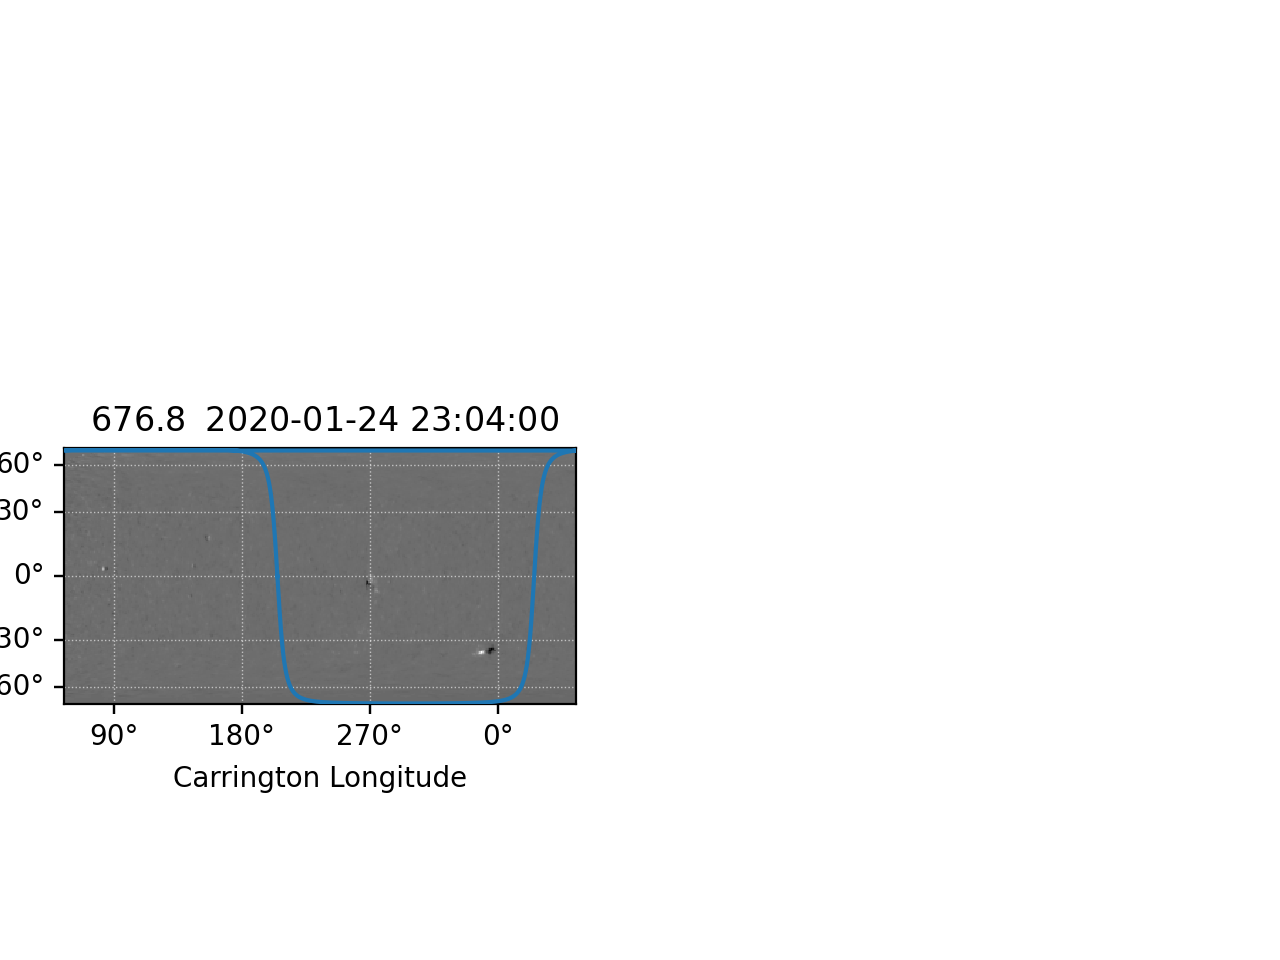

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [10]:
%matplotlib notebook
ax = plt.axes((0.05, 0.2, 0.4, 0.4), projection=gong_map)
limb = get_limb_coordinates(observer=gong_map.observer_coordinate, rsun=6.956e8*u.m, resolution=2000)
frame = wcsapi_to_celestial_frame(ax.wcs)
limb_coord = limb.transform_to(frame)
gong_map.plot(axes=ax)
ax.plot_coord(limb_coord)

In [11]:
%matplotlib inline
color_array = ['white','red','blue']
fig = plt.figure(figsize=(10,8))

ax1 = plt.axes((0.05, 0.2, 0.4, 0.4), projection=kcor_map)
aia_reprojected.plot(axes=ax1, alpha=0.7,clip_interval=(1, 99.9)*u.percent, autoalign=True)
kcor_map.plot_settings["norm"] =  matplotlib.colors.Normalize(np.percentile(kcor_map.data,1), np.percentile(kcor_map.data,99))
kcor_map.plot(axes=ax1)
xlims_world = [-2000, 2000]*u.arcsec
ylims_world = [-2000, 2000]*u.arcsec
world_coords = SkyCoord(Tx=xlims_world, Ty=ylims_world, frame=kcor_map.coordinate_frame)
pixel_coords_x, pixel_coords_y = kcor_map.wcs.world_to_pixel(world_coords)
ax1.set_xlim(pixel_coords_x)
ax1.set_ylim(pixel_coords_y)
title = 'AIA193 '+aia_map.fits_header['DATE-OBS'].replace('T',' ')[0:19] + '\n' + \
        'COSMO/KCor White Light '+ kcor_map.fits_header['DATE-OBS'].replace('T',' ')[0:19] + '\n' + \
        ' '

plt.title(title,fontsize=12)

ax = plt.axes((0.5, 0.2, 0.40, 0.40), projection=kcor_map)
aia_reprojected.plot(axes=ax, alpha=0.7,clip_interval=(1, 99.9)*u.percent, autoalign=True)
kcor_map.plot_settings["norm"] =  matplotlib.colors.Normalize(np.percentile(kcor_map.data,1), np.percentile(kcor_map.data,99))
kcor_map.plot(axes=ax)
 
for fline in field_lines:
    if not fline.coords.lon.size == 0:
#         clear_fline_coords = remove_field_lines_without_in_visible_disk(fline)
#         if not clear_fline_coords.lon.size == 0:
#             ax.plot_coord(clear_fline_coords, color=color_array[int(fline.polarity)], linewidth=0.5)
        ax.plot_coord(fline.coords, color=color_array[int(fline.polarity)], linewidth=0.5)

title = 'AIA193 '+aia_map.fits_header['DATE-OBS'].replace('T',' ')[0:19] + '\n' + \
        'COSMO/KCor White Light '+ kcor_map.fits_header['DATE-OBS'].replace('T',' ')[0:19] + '\n' + \
        'PFSS: Rss='+str(rss)+'Rs'
xlims_world = [-2000, 2000]*u.arcsec
ylims_world = [-2000, 2000]*u.arcsec
world_coords = SkyCoord(Tx=xlims_world, Ty=ylims_world, frame=kcor_map.coordinate_frame)
pixel_coords_x, pixel_coords_y = kcor_map.wcs.world_to_pixel(world_coords)
ax.set_xlim(pixel_coords_x)
ax.set_ylim(pixel_coords_y)
plt.title(title,fontsize=12)
plt.savefig('/Users/chuanpenghou/research/work/MFL/Figure/compare_PFSS_with_EUV_image/PFSS_with_AIA193_RSS_2.png',dpi=300,bbox_inches='tight',facecolor='white')
# plt.show()
plt.close()

In [ ]:
import datetime
import sunpy.coordinates.frames as frames
def Carrington_To_Helioprojective(carr_lon, carr_lat,radius, obstime,observer):
    # 将卡林顿坐标转换到天空平面，比如转到AIA图中x,y,单位角秒。
    Carrington_lon_lat = SkyCoord(lon=carr_lon * u.deg, lat=carr_lat * u.deg,radius=radius*u.R_sun, \
                                  frame=frames.HeliographicCarrington, obstime=obstime, observer=observer)
    helioprojective = Carrington_lon_lat.transform_to(frames.Helioprojective)
#     print(helioprojective)
    x_arcsec = helioprojective.Tx.value
    y_arcsec = helioprojective.Ty.value
    return x_arcsec, y_arcsec

obstime = datetime.datetime(2020,1,25,0,0,0)
Carrington_To_Helioprojective(carr_lon=264, carr_lat=0,radius = 2, obstime=obstime, observer=field_lines[0].coords.observer)

In [ ]:
from astropy.visualization.wcsaxes.wcsapi import wcsapi_to_celestial_frame
from sunpy.coordinates.utils import get_limb_coordinates
fig = plt.figure()

ax = plt.subplot(1, 1, 1, projection=gong_map)
gong_map.plot()
a,b = gong_map.draw_limb()

limb = get_limb_coordinates(observer=gong_map.observer_coordinate, rsun=6.96e8*u.m, resolution=2000)
frame = wcsapi_to_celestial_frame(ax.wcs)
limb_coord = limb.transform_to(frame)
ax.plot_coord(limb_coord)

In [ ]:
# from mplcairo import operator_t
fig = plt.figure()
ax = fig.add_subplot(projection=kcor_map)

aia_reprojected.plot(axes=ax, alpha=0.7,clip_interval=(1, 99.9)*u.percent, autoalign=True)
kcor_map.plot_settings["norm"] =  matplotlib.colors.Normalize(np.percentile(kcor_map.data,1), np.percentile(kcor_map.data,99))
kcor_map.plot(axes=ax)

xlims_world = [-2500, 2500]*u.arcsec
ylims_world = [-2500, 2500]*u.arcsec
world_coords = SkyCoord(Tx=xlims_world, Ty=ylims_world, frame=kcor_map.coordinate_frame)
pixel_coords_x, pixel_coords_y = kcor_map.wcs.world_to_pixel(world_coords)
ax.set_xlim(pixel_coords_x)
ax.set_ylim(pixel_coords_y)
plt.show()